In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
ma_list = [3,5,10,20,30]
stock_symbol = 'AAPL'

df = yf.Ticker(stock_symbol).history(period='3y')
df = df.iloc[:,:-2]

df['Premarket_Change'] = df.Open - df.Close.shift(1)

# Get the Moving Average data
# for col in ['Close','Volume']:
#     for ma in ma_list:
#         df[f'{col}_{ma}MA'] = df[col].rolling(ma).mean().shift(1)

df.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df.values)

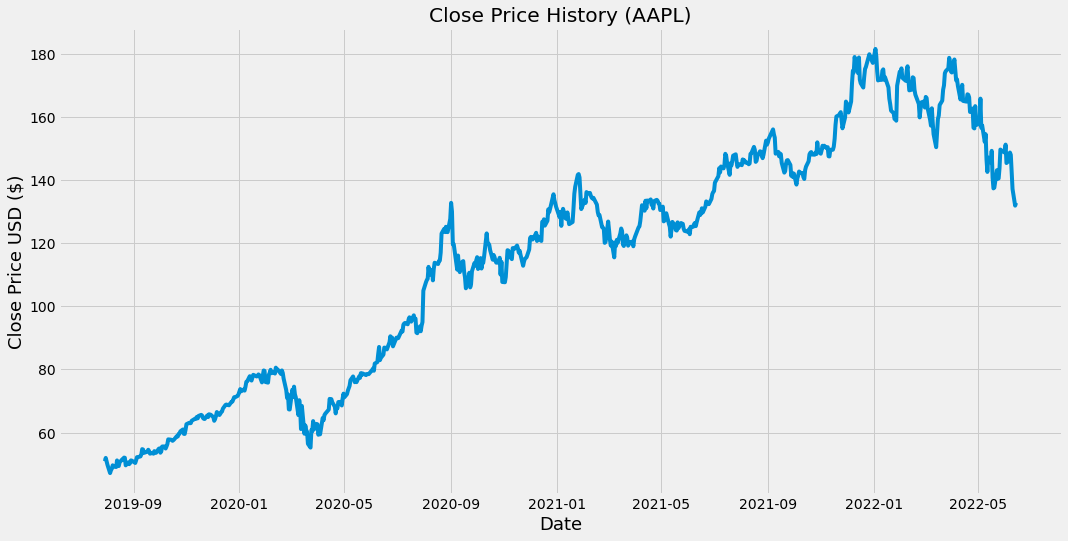

In [5]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title(f'Close Price History ({stock_symbol})')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [15]:
# Construct train and test data set
num_timestamp = 30
train_length = math.ceil(len(df) * 0.9)

# Creating training data set
train = scaled_df[:train_length,:]
x_train = []
y_train = []

for i in range(num_timestamp, train_length):
    x_train.append(train[i-num_timestamp:i,:])
    y_train.append(train[i,3])

x_train, y_train = np.array(x_train), np.array(y_train)

# Creating testing data set
test = scaled_df[train_length - num_timestamp: ,:]
x_test = []
y_test = df['Close'][train_length:].values

for i in range(num_timestamp, len(test)):
    x_test.append(test[i-num_timestamp:i,:])

x_test = np.array(x_test)

# LSTM expect the input to be 3D in the form of (# of samples, timestamp, # of features)
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')

Shape of x_train: (650, 30, 6)
Shape of x_test: (75, 30, 6)


In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(num_timestamp,x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5)
# model.save(f'model/LSTMStockModel({stock_symbol}).h5')

Epoch 1/5
650/650 [==============================] - 12s 15ms/step - loss: 0.0037
Epoch 2/5
650/650 [==============================] - 7s 11ms/step - loss: 0.0017
Epoch 3/5
650/650 [==============================] - 12s 18ms/step - loss: 0.0015
Epoch 4/5
650/650 [==============================] - 14s 22ms/step - loss: 0.0010
Epoch 5/5
650/650 [==============================] - 12s 19ms/step - loss: 0.0010


In [53]:
# model = load_model(f'model/LSTMStockModel({stock_symbol}).h5')

In [20]:
# Get the model predicted price values
predictions = model.predict(x_test)
# Create a matrix for fitting in the scaler
temp_matrix = np.zeros((predictions.shape[0], df.shape[1]))
temp_matrix[:,3] = np.reshape(predictions, (predictions.shape[0],))
predictions = temp_matrix
# Unscaling the value
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:,3]

3/3 [==============================] - 0s 9ms/step


In [21]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6.077567717729635

/Users/Andy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


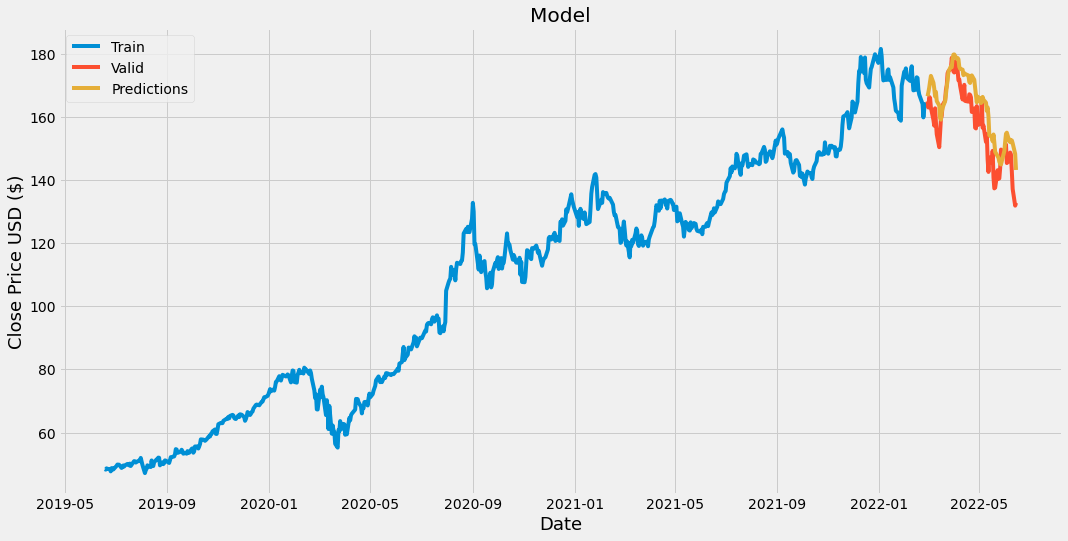

In [22]:
# Plot the data
train = df[:train_length]
valid = df[train_length:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'])
plt.show()

In [29]:
def percent_diff(x, y):
    return (x-y)/y

max_profit_mark = 0
profit_mark = 1
stock_mark = 0
profit_list = []
last_day_price = [scaler.inverse_transform(x_test[0])[-1][3]] + list(y_test[:-1])
predict_price = list(predictions)
actual_price = list(y_test)
option_list = [] # 'Buy', 'Sell', 'Hold', 'Idle'
refer_list = []


for i in range(len(predictions)):
    if profit_mark <= 0:
        break

    refer_list.append(1 + percent_diff(actual_price[i], actual_price[0]))

    if i == 0 and predict_price[i] > last_day_price[i]:
        option_list.append('Buy')
        stock_mark = last_day_price[i]
        percentage_change = percent_diff(actual_price[i], stock_mark)
        profit_list.append(profit_mark * (1 + percentage_change))
        if profit_list[-1] > max_profit_mark:
            max_profit_mark = profit_list[-1]
        continue
    elif i == 0 and predict_price[i] <= last_day_price[i]:
        option_list.append('Idle')
        profit_list.append(profit_mark)
        continue

    if option_list[i-1] in ['Buy', 'Hold']:
        predict_percentage_change = (predict_price[i] - stock_mark) / stock_mark
        predict_profit =  profit_mark * (1 + predict_percentage_change)

        if percent_diff(predict_profit, max_profit_mark) <= -0.05:
            # Terminate the 'Hold'
            option_list.append('Sell')
            profit_list.append(profit_list[-1])
            profit_mark = profit_list[-1]
        else:
            option_list.append('Hold')
            percentage_change = percent_diff(actual_price[i], stock_mark)
            profit_list.append(profit_mark * (1 + percentage_change))
    elif option_list[i-1] in ['Sell', 'Idle']:
        # Can either Buy or Idle
        if predict_price[i] > last_day_price[i]:
            option_list.append('Buy')
            stock_mark = last_day_price[i]
            percentage_change = percent_diff(actual_price[i], stock_mark)
            profit_list.append(profit_mark * (1 + percentage_change))
        else:
            option_list.append('Idle')
            profit_list.append(profit_mark)
    
    
    if profit_list[-1] > max_profit_mark:
        max_profit_mark = profit_list[-1]

profit_df = pd.DataFrame({
    'Last Day Price': last_day_price,
    'Predict Price': predict_price,
    'Actual Price': actual_price,
    'Option': option_list,
    'Profit': profit_list,
    'Reference': refer_list
})
profit_df

,Last Day Price,Predict Price,Actual Price,Option,Profit,Reference
0,164.608154,166.537851,164.877747,Buy,1.001638,1.000000
1,164.877747,167.823903,162.960571,Hold,0.989991,0.988372
2,162.960571,169.307441,166.315643,Hold,1.010373,1.008721
3,166.315643,171.205832,165.986115,Hold,1.008371,1.006722
4,165.986115,172.977864,162.930603,Hold,0.989809,0.988190
...,...,...,...,...,...,...
70,148.710007,151.934822,147.960007,Hold,1.011649,0.897392
71,147.960007,152.551292,142.639999,Hold,0.975275,0.865126
72,142.639999,151.642372,137.130005,Hold,0.937601,0.831707
73,137.130005,148.264183,131.880005,Sell,0.937601,0.799865


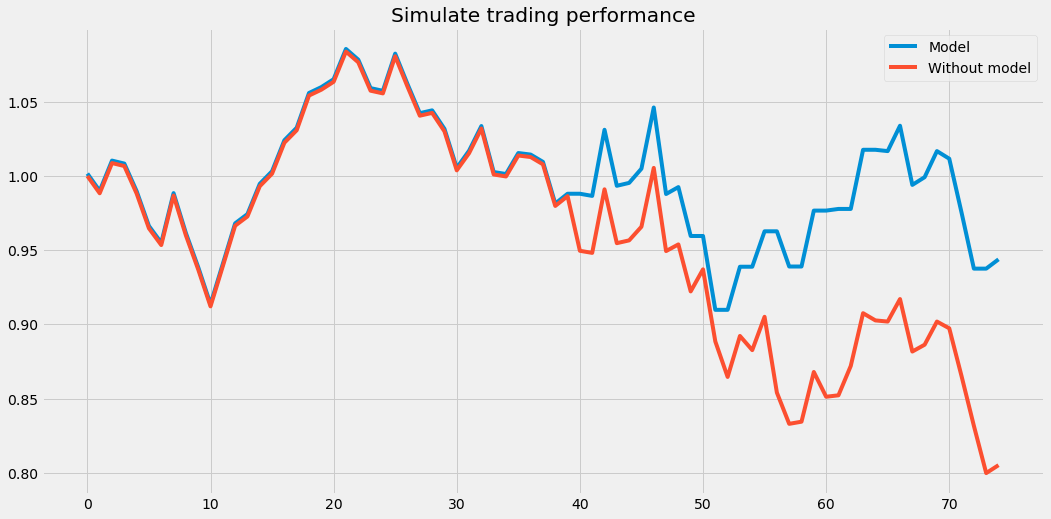

In [30]:
plt.figure(figsize=(16,8))
plt.title('Simulate trading performance')
plt.plot(profit_df['Profit'], label='Model')
plt.plot(profit_df['Reference'], label='Without model')
plt.legend()
plt.show()